In [230]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [231]:
tickers = ['s', 'MSFT', 'AMZN', 'RKLB', 'GOOGL']

rf = 0.03

df = yf.download(tickers, start="2018-01-01", end="2025-05-31", auto_adjust=False)
adj_close = df['Adj Close'] 

[*********************100%***********************]  5 of 5 completed


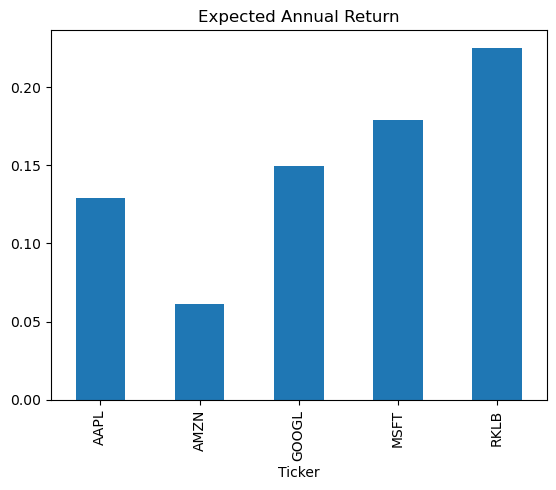

In [232]:
# === Step 2: Compute log returns ===
df_lr = np.log(adj_close / adj_close.shift(1)).dropna()

# === Step 3: Compute annualised mean returns and covariance matrix ===
mean_returns = df_lr.mean() * 252
cov_matrix = df_lr.cov() * 252

mean_returns.plot(kind = 'bar')
plt.title('Expected Annual Return');

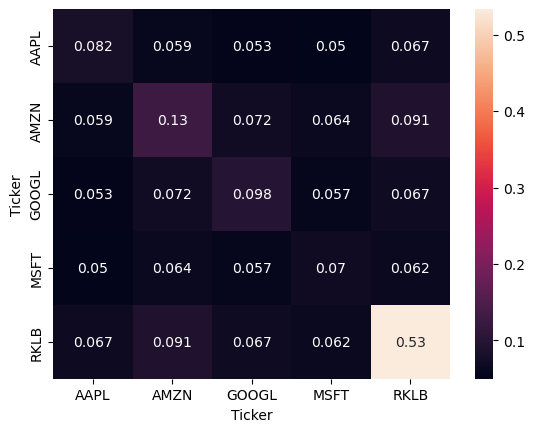

In [233]:
sns.heatmap(cov_matrix,annot=True);

In [234]:
# === Step 4: Define functions ===

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def portfolio_volatility(weights, cov_matrix):
    port_var = np.dot(weights, np.dot(cov_matrix, weights))
    return np.sqrt(port_var)

def sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    ret = portfolio_return(weights, mean_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    return (ret - rf) / vol

# === Step 5: Input weights and calculate ===
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # Equal allocation

port_ret = portfolio_return(weights, mean_returns)
port_vol = portfolio_volatility(weights, cov_matrix)
port_sr = sharpe_ratio(weights, mean_returns, cov_matrix, rf)

# === Step 6: Output ===
print(f"Expected Annual Return: {port_ret:.4f}")
print(f"Annualised Volatility: {port_vol:.4f}") # sd
print(f"Portfolio Sharpe Ratio: {port_sr:.4f}")

Expected Annual Return: 0.1488
Annualised Volatility: 0.2960
Portfolio Sharpe Ratio: 0.4013


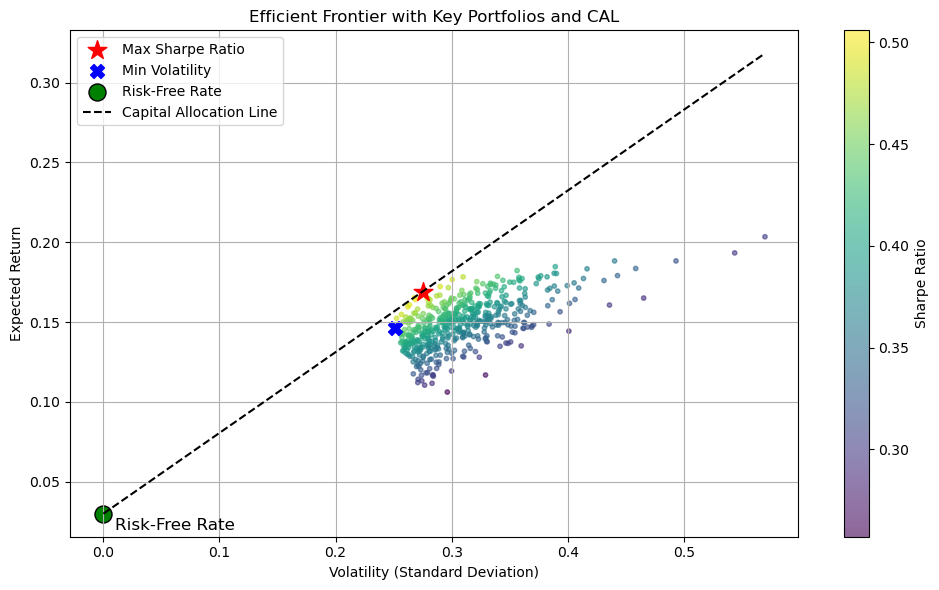

In [253]:
def rand_weights(tickers):
    a = np.random.random(len(tickers))
    a /= a.sum()
    return a;

n_portfolios = 500
results = np.zeros((3, n_portfolios))
all_weights = []

for i in range(n_portfolios):
    weights = rand_weights(tickers)
    all_weights.append(weights)
    
    ret = portfolio_return(weights, mean_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    sr = sharpe_ratio(weights, mean_returns, cov_matrix, rf)

    results[0, i] = ret
    results[1, i] = vol
    results[2, i] = sr
    
# Key portfolio 

# Get index of max Sharpe ratio and min volatility
max_sr_idx = np.argmax(results[2])
min_vol_idx = np.argmin(results[1])

# Optimal portfolios
max_sr_ret = results[0, max_sr_idx]
max_sr_vol = results[1, max_sr_idx]

min_vol_ret = results[0, min_vol_idx]
min_vol_vol = results[1, min_vol_idx]

# === Step 6: Plot Efficient Frontier ===

plt.figure(figsize=(10, 6))

# Efficient Frontier
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', marker='o', s=10, alpha=0.6)
plt.colorbar(label='Sharpe Ratio')

# Max Sharpe (Tangency Portfolio)
plt.scatter(max_sr_vol, max_sr_ret, color='red', marker='*', s=200, label='Max Sharpe Ratio')

# Min Volatility Portfolio
plt.scatter(min_vol_vol, min_vol_ret, color='blue', marker='X', s=100, label='Min Volatility')

plt.scatter(0, rf, color='green', marker='o', s=150, edgecolors='black', label='Risk-Free Portfolio')
plt.annotate('Risk-Free Portfolio', 
             xy=(0, rf), 
             xytext=(0.01, rf - 0.01), 
             fontsize=12)

# Capital Allocation Line (CAL)
x = np.linspace(0, max(results[1]), 100)
cal_y = rf + (max_sr_ret - rf) / max_sr_vol * x
plt.plot(x, cal_y, color='black', linestyle='--', label='Capital Allocation Line')
# Force the y-axis to start at 0 to see the intercept

# Labels and legend
plt.title('Efficient Frontier with Key Portfolios and CAL')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [254]:
# --- Create the original DataFrame for weights ---
df_weights = pd.DataFrame({
    'Ticker': tickers,
    'Max Sharpe Weight': optimal_sharpe_weights,
    'Min Vol Weight': min_vol_weights
})

print("=== Portfolio Asset Weights ===")
print(df_weights.to_string(index=False))


# --- Calculate Metrics for Each Optimal Portfolio ---
# Max Sharpe Portfolio metrics
max_sharpe_ret = portfolio_return(optimal_sharpe_weights, mean_returns)
max_sharpe_vol = portfolio_volatility(optimal_sharpe_weights, cov_matrix)
max_sharpe_sr = sharpe_ratio(optimal_sharpe_weights, mean_returns, cov_matrix, rf)

# Min Volatility Portfolio metrics
min_vol_ret = portfolio_return(min_vol_weights, mean_returns)
min_vol_vol = portfolio_volatility(min_vol_weights, cov_matrix)
min_vol_sr = sharpe_ratio(min_vol_weights, mean_returns, cov_matrix, rf)


# --- Create a new DataFrame for portfolio summary ---
portfolio_summary_data = {
    'Expected Return': [max_sharpe_ret, min_vol_ret],
    'Volatility': [max_sharpe_vol, min_vol_sr],
    'Sharpe Ratio': [max_sharpe_sr, min_vol_sr]
}

df_summary = pd.DataFrame(portfolio_summary_data, index=['Max Sharpe Portfolio', 'Min Volatility Portfolio'])

print("\n\n=== Key Portfolio Performance Summary ===")
df_summary

=== Portfolio Asset Weights ===
Ticker  Max Sharpe Weight  Min Vol Weight
  AAPL           0.011324        0.316052
  MSFT           0.017565        0.002447
  AMZN           0.011994        0.138570
  RKLB           0.880837        0.537934
 GOOGL           0.078279        0.004997


=== Key Portfolio Performance Summary ===


,Expected Return,Volatility,Sharpe Ratio
Max Sharpe Portfolio,0.179700,0.266152,0.562458
Min Volatility Portfolio,0.159192,0.521678,0.521678
